In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


**FUNCIONS DE L'APP**

In [3]:
def carregar_dades(ciutat):
    # Població
    df_poblacio = pd.read_csv(f'dat/{ciutat}/poblacio.csv', skiprows=10, sep=";", decimal=",")
    df_poblacio.rename(columns={"Unnamed: 0":"Any", "Total":"Població"}, inplace=True)
    df_poblacio = df_poblacio.set_index("Any")
    df_poblacio = df_poblacio[['Població']]
    
    # Densitat
    df_densitat = pd.read_csv(f'dat/{ciutat}/densitat.csv', skiprows=6, sep=";", decimal=',')
    df_densitat.rename(columns={"Unnamed: 0":"Any", "Superfície (km²)":"Superfície", "Densitat (hab./km²)":"Densitat"}, inplace=True)
    df_densitat.set_index("Any", inplace=True)
    df_densitat = df_densitat[['Superfície', 'Densitat']]
    
    # Naixements
    df_naixements = pd.read_csv(f'dat/{ciutat}/naixements.csv', skiprows=8, sep=";")
    df_naixements.rename(columns={"Unnamed: 0":"Any", "Total":"Naixements"}, inplace=True)
    df_naixements.set_index("Any", inplace=True)
    df_naixements = df_naixements[['Naixements']]
    
    # Defuncions
    df_defuncions = pd.read_csv(f'dat/{ciutat}/defuncions.csv', skiprows=7, sep=";")
    df_defuncions.rename(columns={"Unnamed: 0":"Any", "Total":"Defuncions"}, inplace=True)
    df_defuncions.set_index("Any", inplace=True)
    df_defuncions = df_defuncions[['Defuncions']]

    # Aturats
    df_atur = pd.read_csv(f'dat/{ciutat}/atur.csv', skiprows=6, sep=";", decimal=',')
    df_atur.rename(columns={"Unnamed: 0":"Any", "Sexe. Total":"Aturats"}, inplace=True)
    df_atur = df_atur.set_index("Any")
    df_atur = df_atur[['Aturats']]

    # Pensionistes
    df_pensionistes = pd.read_csv(f'dat/{ciutat}/pensionistes.csv', skiprows=7, sep=";")
    df_pensionistes.rename(columns={'Unnamed: 0':'Any', 'Total':'Pensionistes'}, inplace=True)
    df_pensionistes = df_pensionistes.set_index("Any")
    df_pensionistes = df_pensionistes[['Pensionistes']]

    # Habitatges acabats
    df_habit = pd.read_csv(f'dat/{ciutat}/habitatges_construits.csv', skiprows=10, sep=";")
    noves_col = {
        'Unnamed: 0':'Any',
        'Habitatges iniciats amb protecció oficial':'HPO iniciats',
        'Habitatges acabats amb protecció oficial':'HPO acabats'
    }
    df_habit.rename(columns=noves_col, inplace=True)
    df_habit.set_index('Any', inplace=True)
    df_habit = df_habit[['HPO acabats', 'Habitatges acabats']]

    # Vehicles
    df_vehicles = pd.read_csv(f'dat/{ciutat}/vehicles.csv', skiprows=6, sep=";")
    df_vehicles.rename(columns={'Unnamed: 0':'Any'}, inplace=True)
    df_vehicles.set_index('Any', inplace=True)
    df_vehicles = df_vehicles[['Turismes', 'Motocicletes']]

    # Renta Familiar Disponible per Habitant
    df_rdf = pd.read_csv(f'dat/{ciutat}/rfd.csv', skiprows=6, sep=";")
    df_rdf.rename(columns={"Unnamed: 0":"Any",'Per habitant (€)':'RFDH' }, inplace=True)
    df_rdf = df_rdf.set_index("Any")
    df_rdf = df_rdf[['RFDH']]

    # Saldo de migracions internes
    df_migracionsint = pd.read_csv(f'dat/{ciutat}/migracions_internes.csv', skiprows=7, sep=";", decimal=",")
    df_migracionsint.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions internes'}, inplace=True)
    df_migracionsint = df_migracionsint.set_index("Any")
    df_migracionsint = df_migracionsint[['Migracions internes']]

    # Saldo de migracions externes
    df_migracionsext = pd.read_csv(f'dat/{ciutat}/migracions_externes.csv', skiprows=8, sep=";", decimal=",")
    df_migracionsext.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions externes'}, inplace=True)
    df_migracionsext = df_migracionsext.set_index("Any")
    df_migracionsext = df_migracionsext[['Migracions externes']]
    
    df = pd.concat([df_poblacio, df_densitat, df_naixements, df_defuncions, df_migracionsint, df_migracionsext,
                    df_atur, df_pensionistes, df_habit, df_vehicles, df_rdf], axis=1).sort_index(ascending=True)
    
    return df

def neteja_dades (df):
    df = df.drop(range(1975,2010))
    df.drop(2025, inplace=True)
    df['Població'] = df['Població'].fillna(round(df['Densitat']* df['Superfície'], 0)) # Omplim els NAN amb Densitat * Superfície
    df.loc[2015, 'Pensionistes'] = round((df['Pensionistes'][2016]+df['Pensionistes'][2014])/2, 0) # Omplim els NAN amb una interpolació lineal
    df.loc[2010, 'Pensionistes'] = round(2 * df.loc[2011, 'Pensionistes'] - df.loc[2012, 'Pensionistes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2023, 'RFDH'] = round(2 * df.loc[2022, 'RFDH'] - df.loc[2021, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'RFDH'] = round(2 * df.loc[2023, 'RFDH'] - df.loc[2022, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions internes'] = round(2 * df.loc[2023, 'Migracions internes'] - df.loc[2022, 'Migracions internes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions externes'] = round(2 * df.loc[2023, 'Migracions externes'] - df.loc[2022, 'Migracions externes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.drop(columns='Superfície', inplace=True)
    return df

def afegir_taxes (df):
    df['Taxa natalitat'] = round(df.Naixements * 100 / df.Població, 2)
    df['Taxa mortalitat'] = round(df.Defuncions * 100 / df.Població, 2)
    df['Taxa atur'] = round(df.Aturats * 100 / df.Població, 2)
    df['Taxa dependència'] = round(df.Pensionistes * 100 / df.Població, 2)
    df['Taxa HPO'] = round(df['HPO acabats'] * 1000 / df.Població, 2)
    df['Taxa habitatges'] = round(df['Habitatges acabats'] * 1000 / df.Població, 2)
    df['Taxa turismes'] = round(df.Turismes * 100 / df.Població, 2)
    df['Taxa motocicletes'] = round(df.Motocicletes * 100 / df.Població, 2)
    return df


**CÀRREGA DE LES DADES I ANÀLISI EXPLORATORI**

In [4]:
ciutat = "Terrassa"
df = carregar_dades (ciutat)
df = neteja_dades (df)
df

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
Any,,,,,,,,,,,,,
2010,212725.0,3032.0,2849.0,1587.0,266.0,2259.0,20033.0,39725.0,277.0,675.0,94652.0,13705.0,16250.0
2011,214406.0,3045.9,2840.0,1520.0,608.0,2147.0,21496.7,40579.0,86.0,159.0,94562.0,14180.0,16226.0
2012,215679.0,3074.1,2764.0,1537.0,289.0,1553.0,23059.3,41433.0,416.0,294.0,94315.0,14447.0,15506.0
2013,215054.0,3065.2,2394.0,1625.0,-144.0,1467.0,23756.5,41781.0,25.0,132.0,93275.0,14627.0,15084.0
2014,215517.0,3071.8,2366.0,1594.0,296.0,1589.0,22109.3,42143.0,0.0,71.0,93156.0,15038.0,15476.0
2015,215216.0,3067.5,2330.0,1687.0,338.0,2089.0,19967.7,42418.0,0.0,30.0,94480.0,15562.0,16140.0
2016,215125.0,3066.2,2255.0,1703.0,642.0,2620.0,17650.4,42694.0,2.0,152.0,96716.0,16172.0,16578.0
2017,216430.0,3084.8,2105.0,1766.0,406.0,3085.0,15333.1,43081.0,6.0,69.0,99421.0,16792.0,16770.0
2018,218534.0,3114.8,2000.0,1801.0,276.0,3883.0,14329.1,43526.0,0.0,43.0,101174.0,17467.0,16986.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
dtypes: float64(13)
memory usage: 2.2 KB


In [6]:
df.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,218779.866667,3119.400000,2185.200000,1727.200000,251.466667,3198.933333,17385.813333,42826.866667,62.400000,260.733333,98456.266667,17038.133333,17007.666667
std,4710.065860,69.603705,401.845066,155.197662,444.114346,1510.329267,4026.272754,1483.137739,120.625631,199.493812,4038.868609,2479.115824,1345.454924
min,212725.000000,3032.000000,1682.000000,1520.000000,-847.000000,1467.000000,12239.900000,39725.000000,0.000000,30.000000,93156.000000,13705.000000,15084.000000
25%,215170.500000,3066.850000,1832.000000,1609.500000,138.500000,2118.000000,14188.950000,41962.000000,2.000000,101.500000,94521.000000,14832.500000,16183.000000
50%,216430.000000,3084.800000,2105.000000,1703.000000,296.000000,2620.000000,16127.800000,43081.000000,21.000000,229.000000,99421.000000,16792.000000,16770.000000
75%,222630.500000,3183.000000,2380.000000,1806.000000,470.500000,4033.500000,20764.850000,43895.000000,39.500000,397.000000,102363.000000,18883.000000,17911.000000
max,228294.000000,3253.900000,2849.000000,2092.000000,1059.000000,5787.000000,23756.500000,44850.000000,416.000000,675.000000,102954.000000,21534.000000,19434.000000


In [7]:
df2 = afegir_taxes(df)
df2


,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
Any,,,,,,,,,,,,,,,,,,,,,
2010,212725.0,3032.0,2849.0,1587.0,266.0,2259.0,20033.0,39725.0,277.0,675.0,...,13705.0,16250.0,1.34,0.75,9.42,18.67,1.30,3.17,44.50,6.44
2011,214406.0,3045.9,2840.0,1520.0,608.0,2147.0,21496.7,40579.0,86.0,159.0,...,14180.0,16226.0,1.32,0.71,10.03,18.93,0.40,0.74,44.10,6.61
2012,215679.0,3074.1,2764.0,1537.0,289.0,1553.0,23059.3,41433.0,416.0,294.0,...,14447.0,15506.0,1.28,0.71,10.69,19.21,1.93,1.36,43.73,6.70
2013,215054.0,3065.2,2394.0,1625.0,-144.0,1467.0,23756.5,41781.0,25.0,132.0,...,14627.0,15084.0,1.11,0.76,11.05,19.43,0.12,0.61,43.37,6.80
2014,215517.0,3071.8,2366.0,1594.0,296.0,1589.0,22109.3,42143.0,0.0,71.0,...,15038.0,15476.0,1.10,0.74,10.26,19.55,0.00,0.33,43.22,6.98
2015,215216.0,3067.5,2330.0,1687.0,338.0,2089.0,19967.7,42418.0,0.0,30.0,...,15562.0,16140.0,1.08,0.78,9.28,19.71,0.00,0.14,43.90,7.23
2016,215125.0,3066.2,2255.0,1703.0,642.0,2620.0,17650.4,42694.0,2.0,152.0,...,16172.0,16578.0,1.05,0.79,8.20,19.85,0.01,0.71,44.96,7.52
2017,216430.0,3084.8,2105.0,1766.0,406.0,3085.0,15333.1,43081.0,6.0,69.0,...,16792.0,16770.0,0.97,0.82,7.08,19.91,0.03,0.32,45.94,7.76
2018,218534.0,3114.8,2000.0,1801.0,276.0,3883.0,14329.1,43526.0,0.0,43.0,...,17467.0,16986.0,0.92,0.82,6.56,19.92,0.00,0.20,46.30,7.99


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
 13  Taxa natalitat       15 non-null     float64
 14  Taxa mortalitat      15 non-null     float64
 15  Taxa atur            15 non-null     float

In [9]:
df2.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,218779.866667,3119.400000,2185.200000,1727.200000,251.466667,3198.933333,17385.813333,42826.866667,62.400000,260.733333,...,17038.133333,17007.666667,1.003333,0.789333,7.979333,19.572000,0.288667,1.184667,44.990667,7.769333
std,4710.065860,69.603705,401.845066,155.197662,444.114346,1510.329267,4026.272754,1483.137739,120.625631,199.493812,...,2479.115824,1345.454924,0.200630,0.061698,1.978966,0.378271,0.562061,0.905127,1.123486,0.965864
min,212725.000000,3032.000000,1682.000000,1520.000000,-847.000000,1467.000000,12239.900000,39725.000000,0.000000,30.000000,...,13705.000000,15084.000000,0.740000,0.710000,5.360000,18.670000,0.000000,0.140000,43.220000,6.440000
25%,215170.500000,3066.850000,1832.000000,1609.500000,138.500000,2118.000000,14188.950000,41962.000000,2.000000,101.500000,...,14832.500000,16183.000000,0.825000,0.750000,6.465000,19.460000,0.010000,0.470000,44.000000,6.890000
50%,216430.000000,3084.800000,2105.000000,1703.000000,296.000000,2620.000000,16127.800000,43081.000000,21.000000,229.000000,...,16792.000000,16770.000000,0.970000,0.780000,7.210000,19.700000,0.090000,1.020000,44.960000,7.760000
75%,222630.500000,3183.000000,2380.000000,1806.000000,470.500000,4033.500000,20764.850000,43895.000000,39.500000,397.000000,...,18883.000000,17911.000000,1.105000,0.820000,9.725000,19.875000,0.180000,1.775000,45.945000,8.465000
max,228294.000000,3253.900000,2849.000000,2092.000000,1059.000000,5787.000000,23756.500000,44850.000000,416.000000,675.000000,...,21534.000000,19434.000000,1.340000,0.940000,11.050000,19.940000,1.930000,3.170000,46.530000,9.430000


**ANÀLISI DESCRIPTIU**

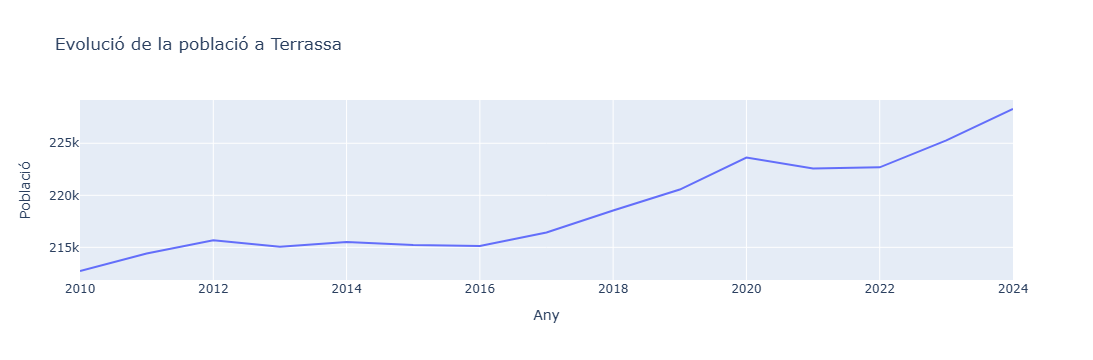

In [10]:
fig = px.line(df2, 
              y='Població',
              title=f'Evolució de la població a {ciutat}'
             )
fig.show()

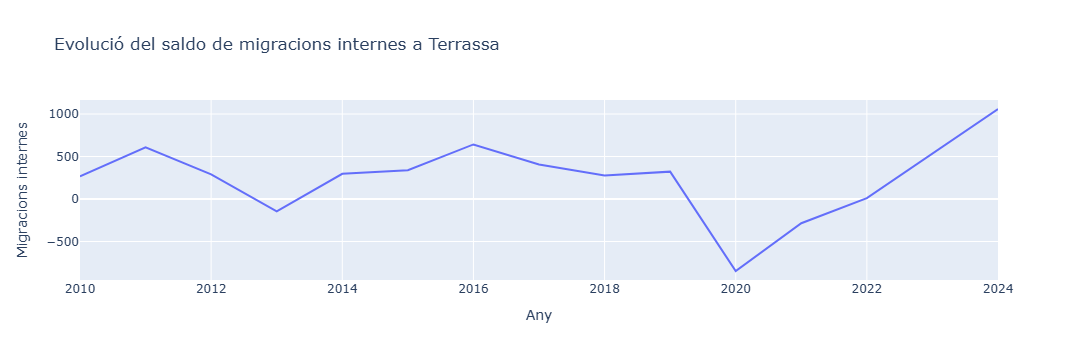

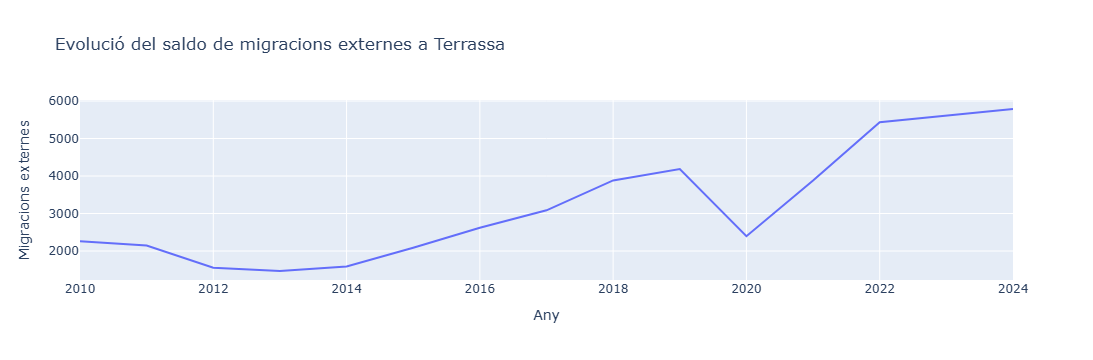

In [11]:
fig = px.line(df2, 
              y='Migracions internes',
              title=f'Evolució del saldo de migracions internes a {ciutat}'
             )
fig2 = px.line(df2,
               y='Migracions externes',
               title=f'Evolució del saldo de migracions externes a {ciutat}'
              )
fig.show()
fig2.show()

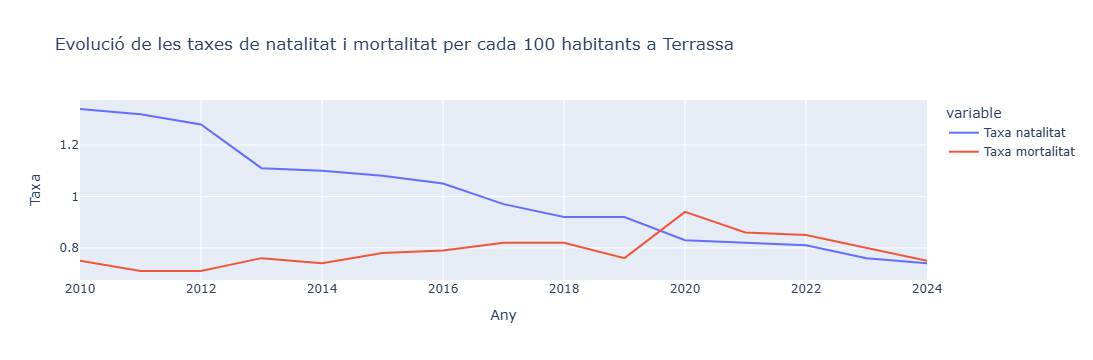

In [12]:
fig = px.line(df2, 
              y=['Taxa natalitat', 'Taxa mortalitat'],
              title=f'Evolució de les taxes de natalitat i mortalitat per cada 100 habitants a {ciutat}',
              labels={'value':'Taxa'}
             )
fig.show()

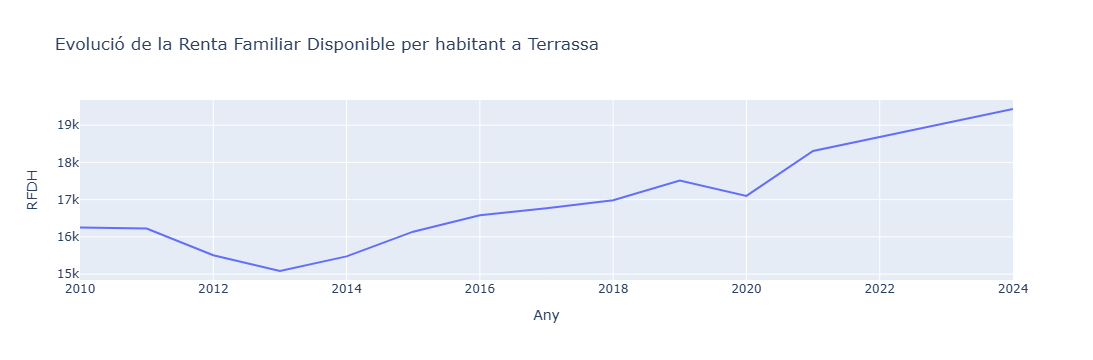

In [13]:
fig = px.line(df2, 
              y='RFDH',
              title=f'Evolució de la Renta Familiar Disponible per habitant a {ciutat}'
             )
fig.show()

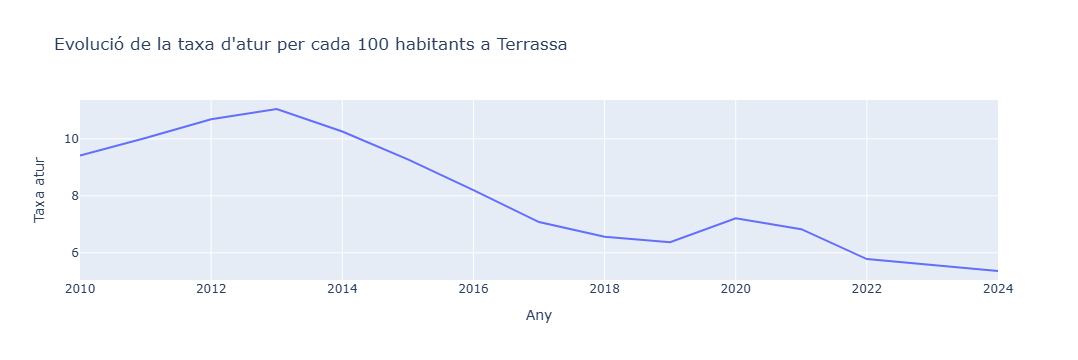

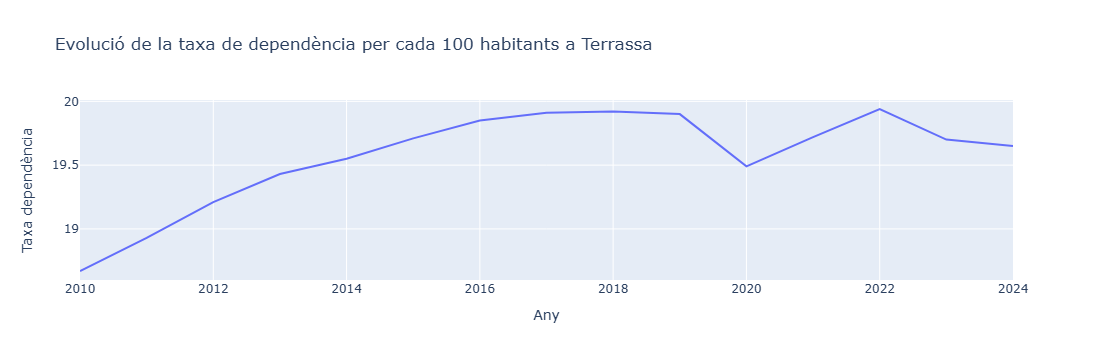

In [14]:
fig = px.line(df2, y='Taxa atur',
              title=f"Evolució de la taxa d'atur per cada 100 habitants a {ciutat}",
              labels={'value':"Taxa d'atur"}
             )
fig2 = px.line(df2, y='Taxa dependència',
               title=f"Evolució de la taxa de dependència per cada 100 habitants a {ciutat}",
               labels={'value':"Taxa de dependència"}
              )
fig.show()
fig2.show()

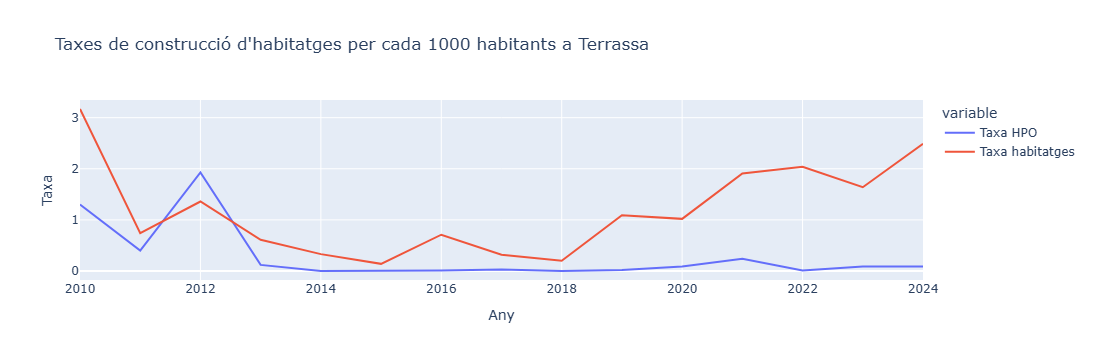

In [15]:
fig = px.line(df2,
              y=['Taxa HPO', 'Taxa habitatges'],
              title=f"Taxes de construcció d'habitatges per cada 1000 habitants a {ciutat}",
              labels={'value':'Taxa'}
             )
fig.show()

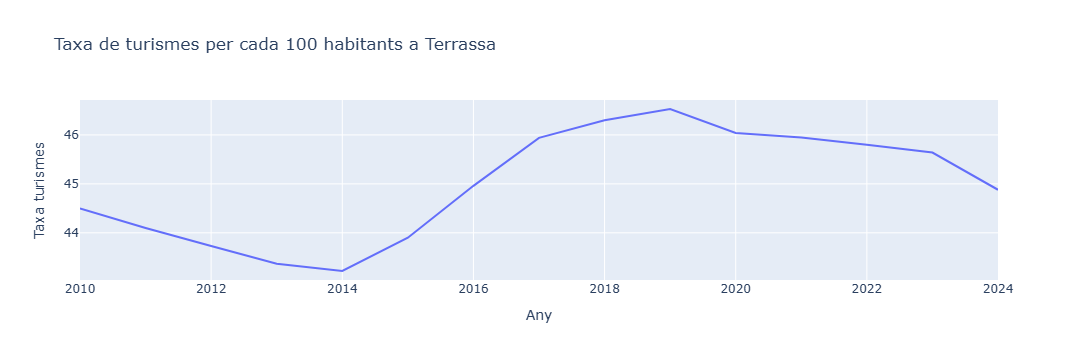

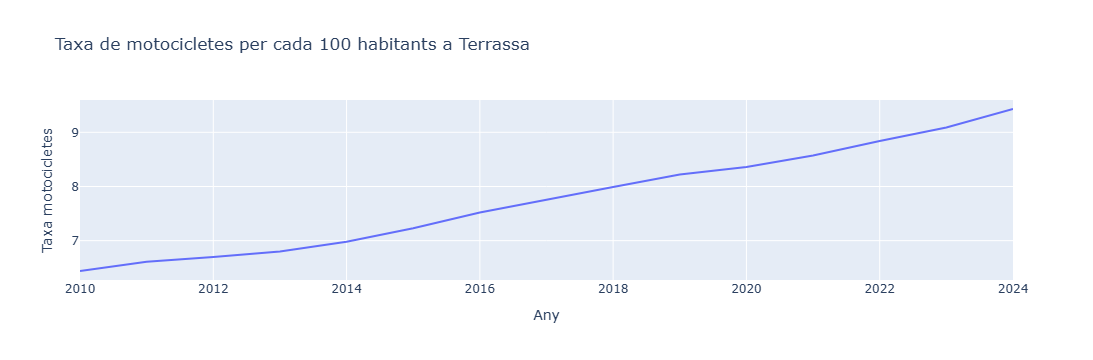

In [16]:
fig = px.line(df2, 
              y='Taxa turismes',
              title=f'Taxa de turismes per cada 100 habitants a {ciutat}'
             )
fig2 = px.line(df2, 
               y='Taxa motocicletes',
               title=f'Taxa de motocicletes per cada 100 habitants a {ciutat}'
              )
fig.show()
fig2.show()

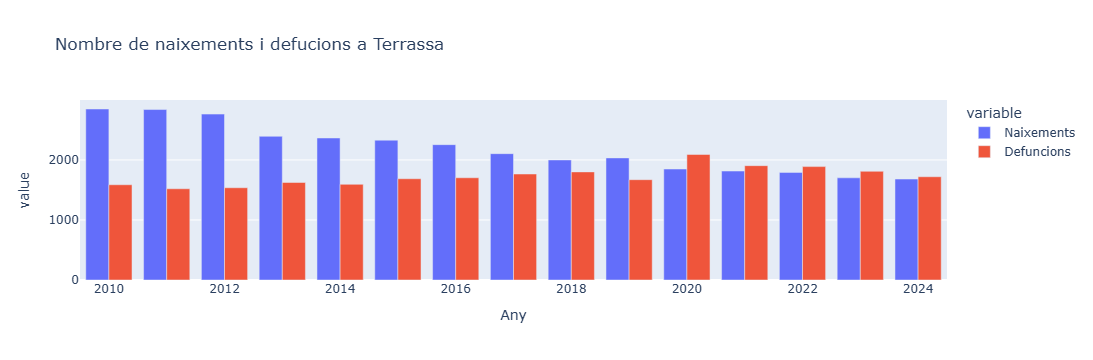

In [17]:
fig = px.bar(df2,
             y= ['Naixements', 'Defuncions'],
             barmode='group',
             title=f'Nombre de naixements i defucions a {ciutat}'
            )
fig.show()

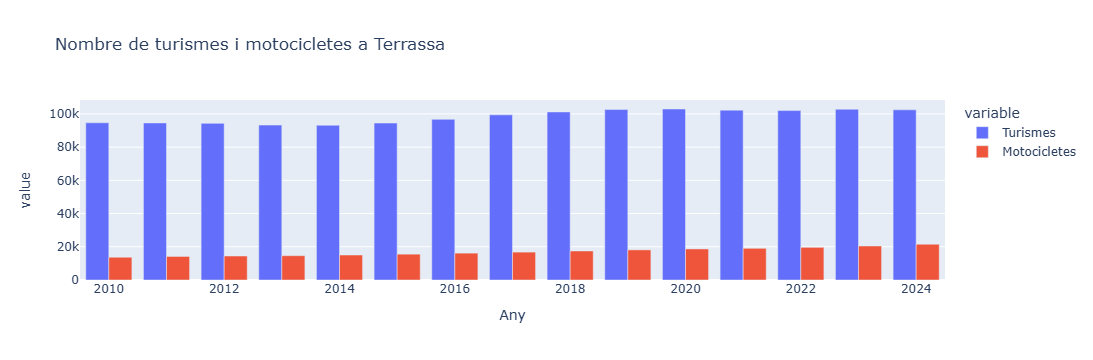

In [18]:
fig = px.bar(df2,
             y= ['Turismes', 'Motocicletes'],
             barmode='group',
             title=f'Nombre de turismes i motocicletes a {ciutat}'
            )
fig.show()

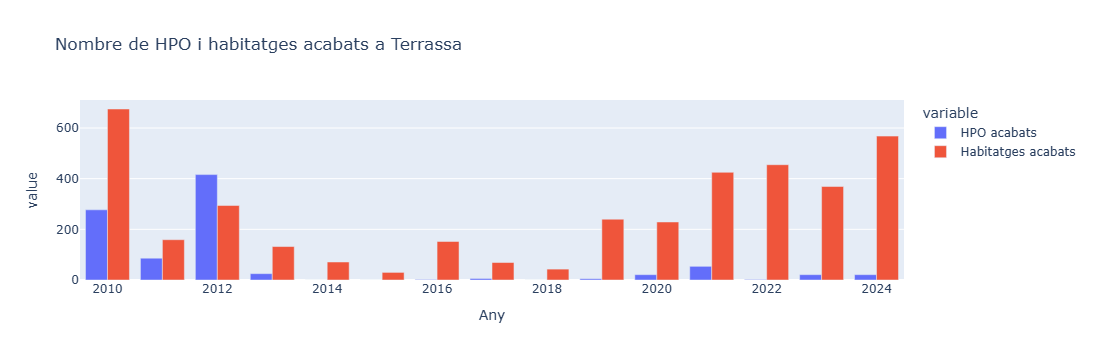

In [19]:
fig = px.bar(df2,
             y= ['HPO acabats', 'Habitatges acabats'],
             barmode='group',
             title=f"Nombre de HPO i habitatges acabats a {ciutat}"
            )
fig.show()

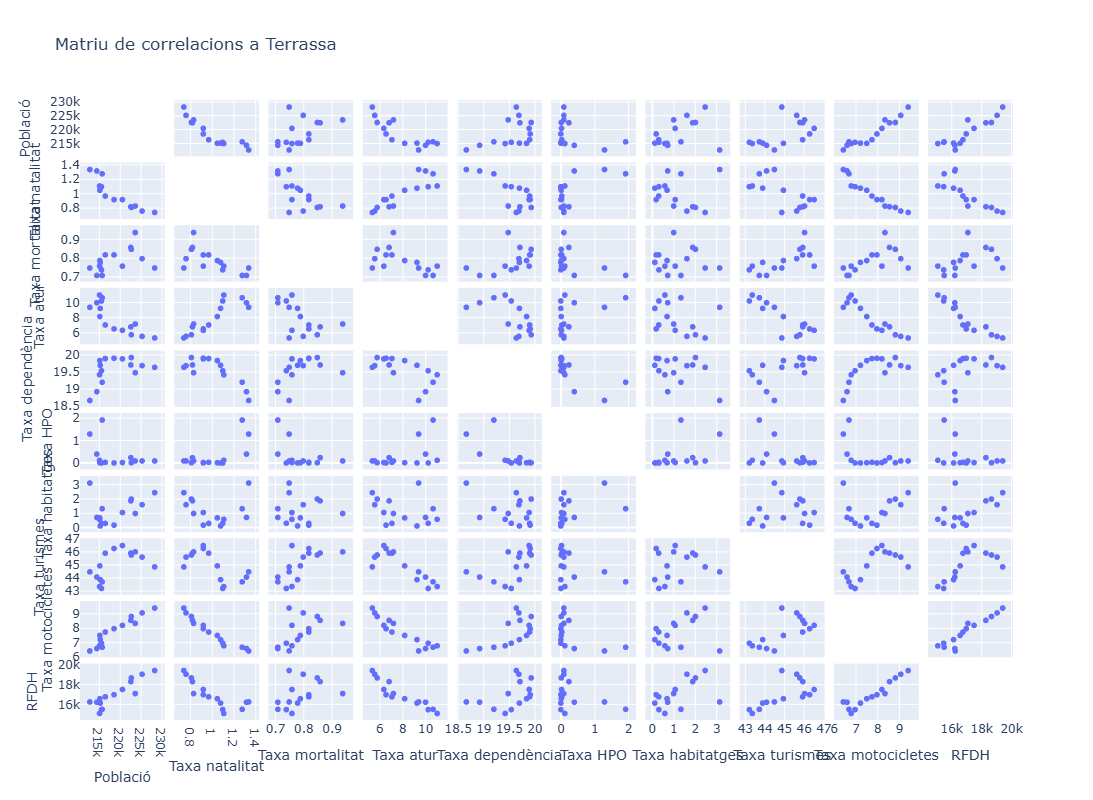

In [20]:
fig = px.scatter_matrix(
    df2,
    dimensions = ['Població', 'Taxa natalitat', 'Taxa mortalitat', 'Taxa atur', 'Taxa dependència',
                  'Taxa HPO', 'Taxa habitatges', 'Taxa turismes', 'Taxa motocicletes', 'RFDH'],
    height=800,
    width=800,
    title=f'Matriu de correlacions a {ciutat}'
)
fig.update_traces(diagonal_visible=False)  # Ocultar histogramas en la diagonal
fig.update_layout(
    dragmode='select',     # Permitir selección de puntos
    hovermode='closest',   # Mostrar datos al pasar el ratón
    font=dict(size=12)
)
fig.show()

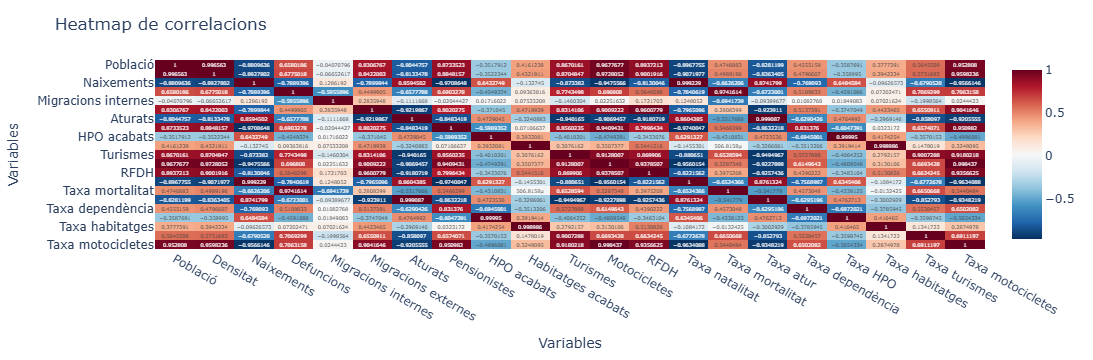

In [21]:
corr = df2.corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

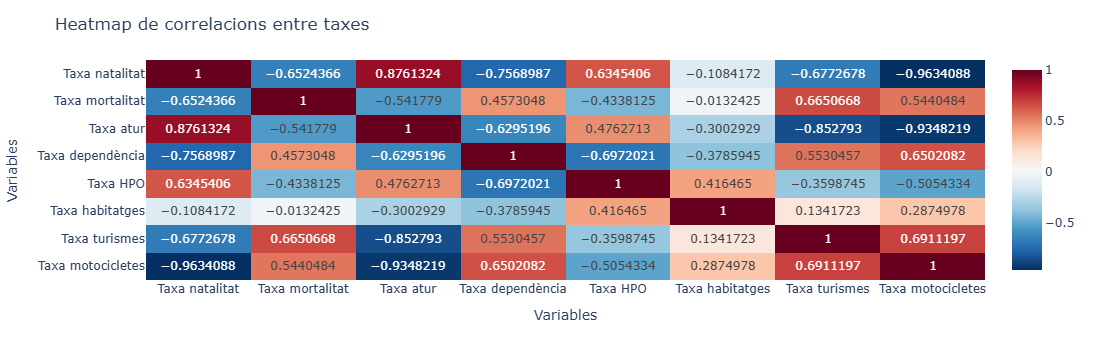

In [22]:
cols = [c for c in df.columns if 'Taxa' in c]
corr = df2[cols].corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions entre taxes', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

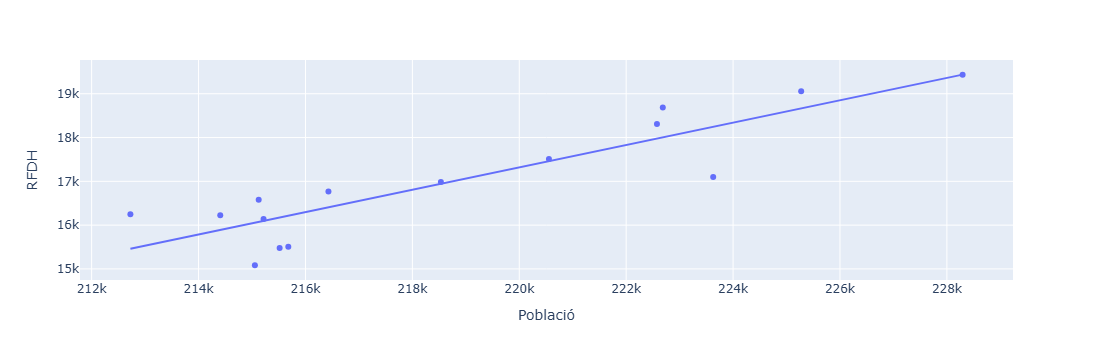

In [23]:
fig = px.scatter(df2, x='Població', y='RFDH', trendline='ols')
fig.show()

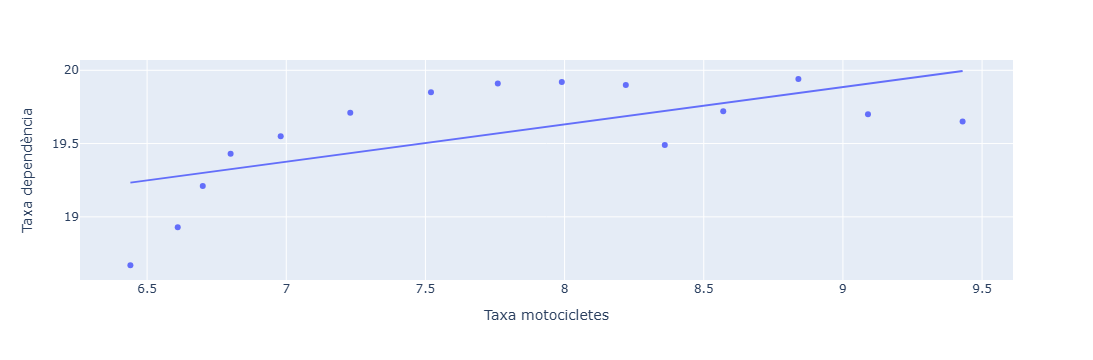

In [24]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa dependència', trendline='ols')
fig.show()

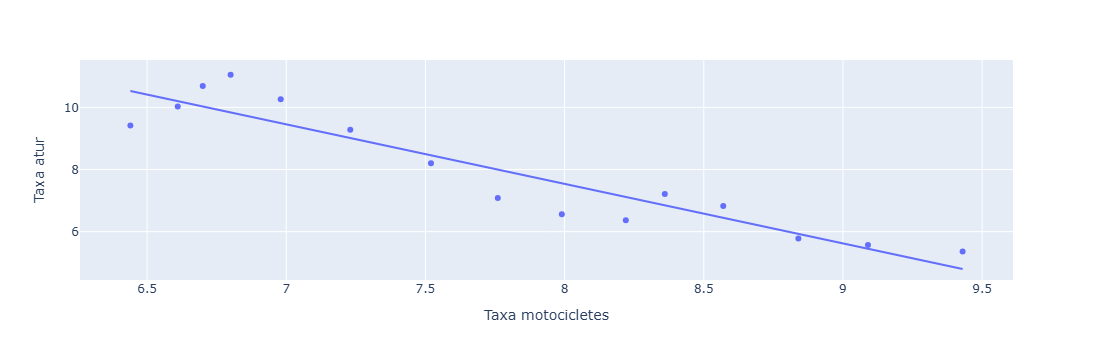

In [25]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa atur', trendline='ols')
fig.show()

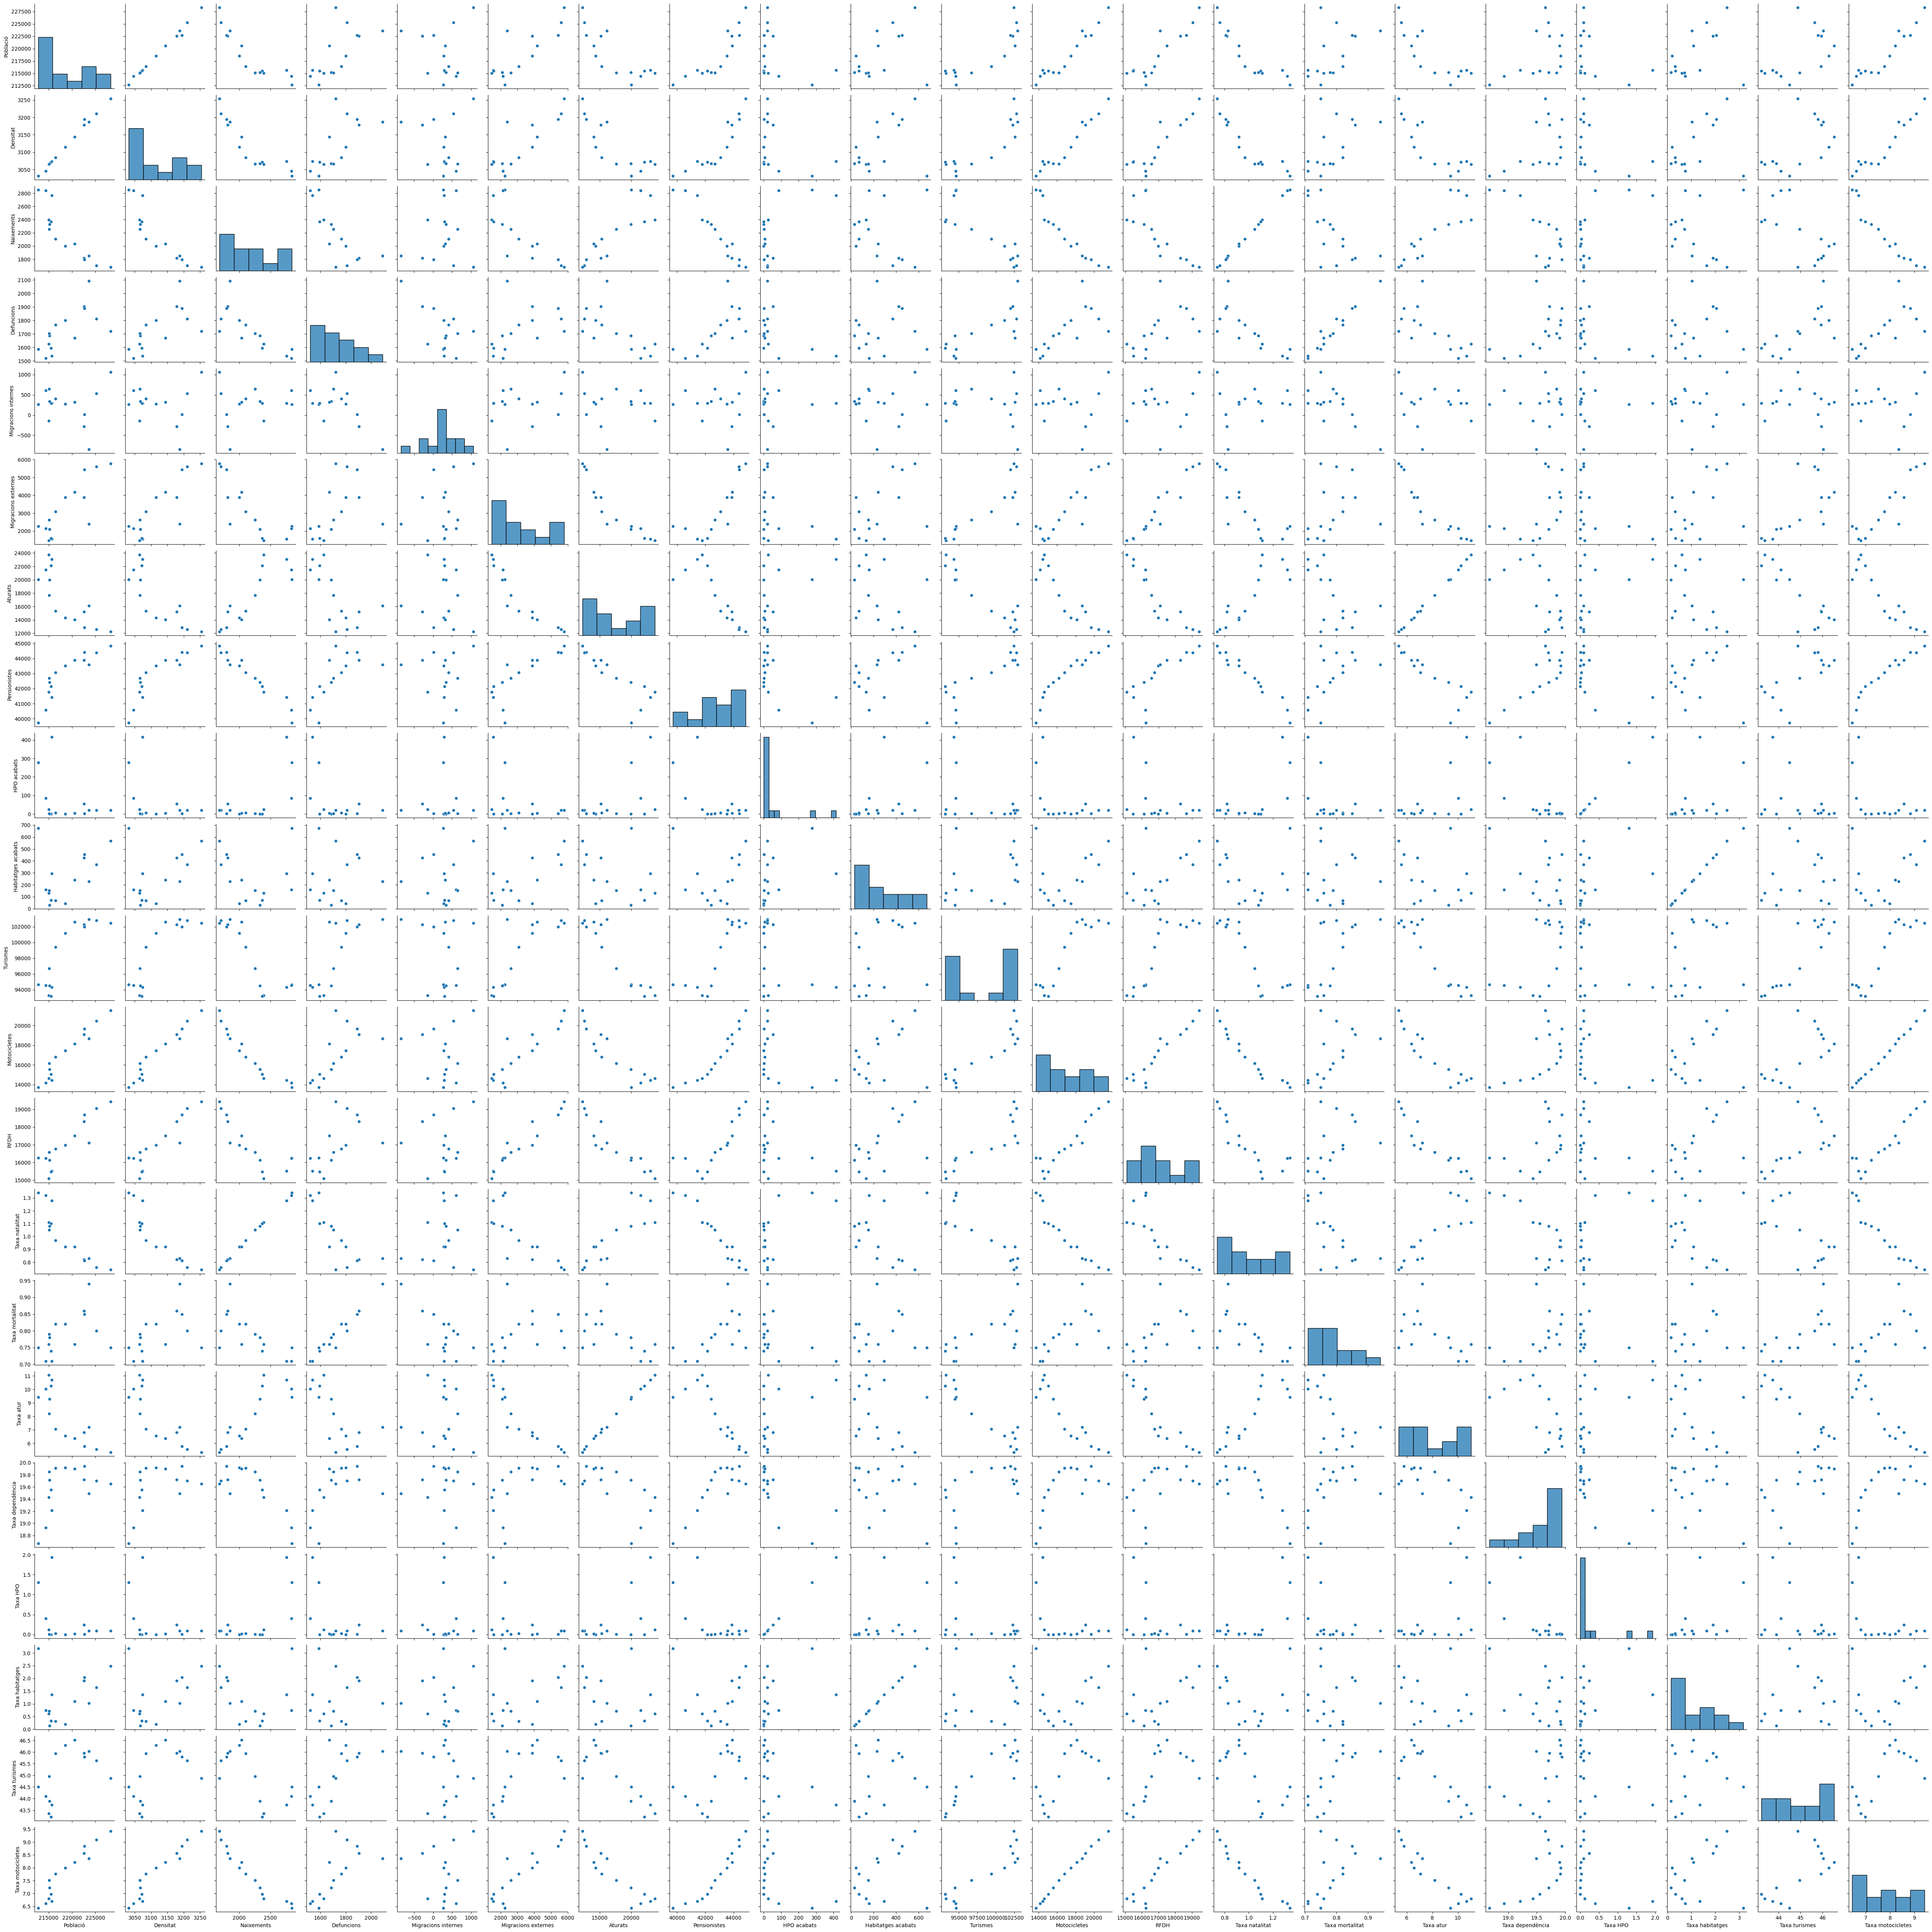

In [26]:
sns.pairplot(df2)
plt.show()

**ANÀLISI PREDICTIU**

              Variable  Coeficient
0           Naixements   -6.387692
1           Defuncions   -2.406384
2  Migracions internes   -1.631234
3  Migracions externes    1.495216
[232521.6650777]
r2 = 0.8324611992173057


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_17764\113110075.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



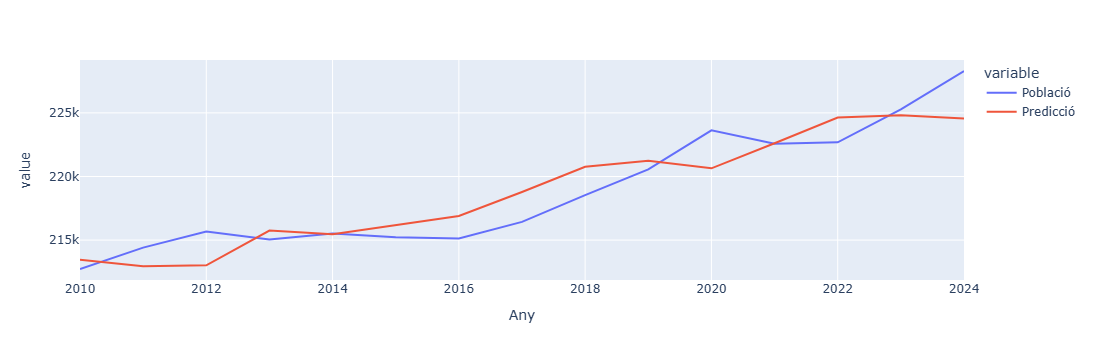

In [27]:
# Predicció de Població segons Naixements, Defuncions i Migracions

X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()


In [28]:
# Predicció de Població segons Naixements, Defuncions i Migracions amb Random Forest

# 1. Seleccionar variables
X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2["Població"]

# 2. Dividir en entrenament i test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Crear i entrenar el model
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)

# 4. Avaluació
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

# 5. Importància de les variables
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


RMSE: 2383.4015803575094
R2: 0.6852571351702322
Naixements             0.600248
Defuncions             0.215878
Migracions externes    0.139527
Migracions internes    0.044347
dtype: float64


              Variable  Coeficient
0           Naixements   -1.319212
1           Defuncions   -3.606823
2              Aturats    0.499812
3         Pensionistes    1.616421
4                 RFDH    3.973673
5  Migracions internes   -1.694863
6  Migracions externes   -0.821819
[85448.68371706]
r2 = 0.9238296008272836


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_17764\1570774157.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



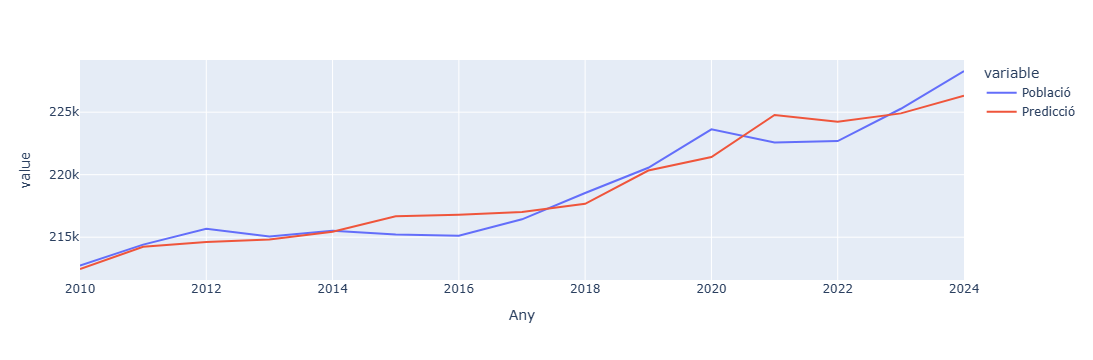

In [29]:
# Predicció de Població segons Naixements, Defuncions, Aturats, Pensionistes, RFDH i Migracions

X = df2[["Naixements", "Defuncions", "Aturats", "Pensionistes", "RFDH", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

              Variable  Coeficient
0             Població    0.218536
1                 RFDH   -0.150455
2           Naixements   -2.409703
3           Defuncions  -15.941254
4  Migracions internes   -2.072009
5  Migracions externes   -1.918361
6         Pensionistes   -0.728191
[42776.77549885]
r2 = 0.954422614031374


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_17764\2175888387.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



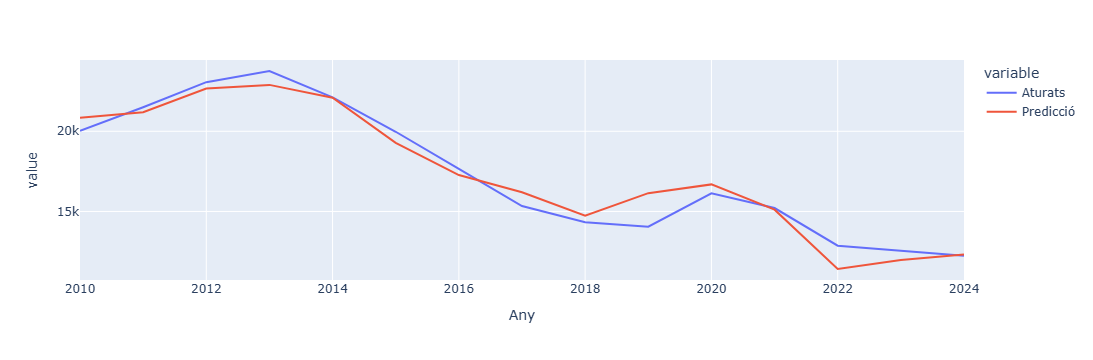

In [30]:
# Predicció del nombre d'Aturats segons Població, RFDH, Naixements, Defuncions i Migracions

X = df2[["Població", "RFDH", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Pensionistes"]]
y = df2[["Aturats"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Aturats']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()



              Variable  Coeficient
0             Població    0.111674
1           Naixements    0.283766
2           Defuncions    2.696520
3  Migracions internes    0.478825
4  Migracions externes    0.615858
5              Aturats   -0.009671
6         Pensionistes   -0.226797
[-4911.28381949]
r2 = 0.9737661091547333


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_17764\791505936.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



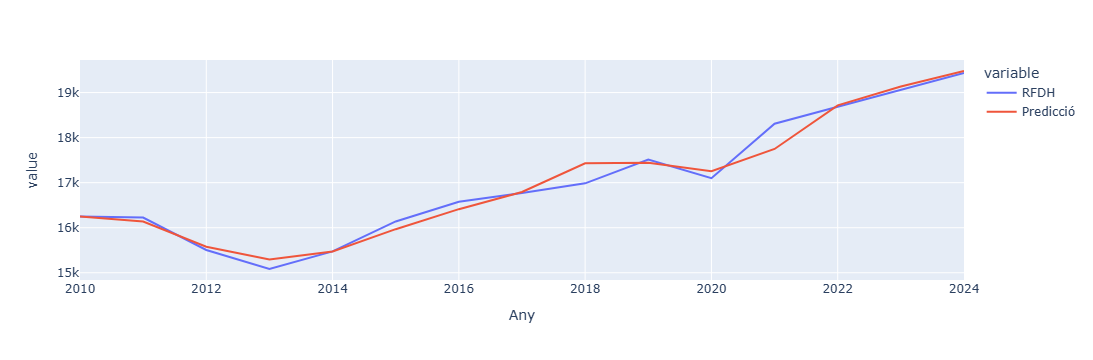

In [31]:
# Predicció del nombre de RFDH segons Població, Naixements, Defuncions, Migracions, Aturats i Pensionistes

X = df2[["Població", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Aturats", "Pensionistes"]]
y = df2[["RFDH"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['RFDH']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

                               SARIMAX Results                                
Dep. Variable:               Població   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -120.842
Date:                Thu, 05 Feb 2026   AIC                            247.683
Time:                        10:30:09   BIC                            249.600
Sample:                    01-01-2010   HQIC                           247.506
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.089     11.256      0.000       0.826       1.174
ma.L1         -0.9989      0.552     -1.809      0.070      -2.081       0.083
sigma2      2.376e+06    1.2e-07   1.97e+13      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



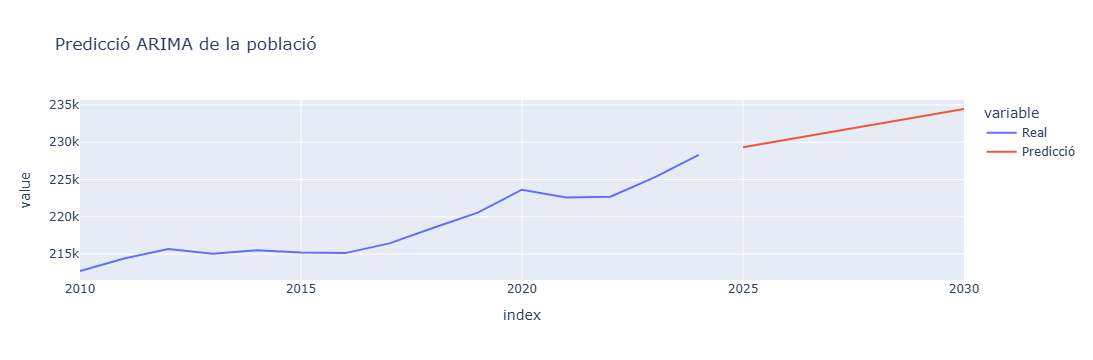

In [32]:
# Prediccions de Població al futur amb ARIMA

s = df2["Població"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de la població")
fig.show()



                               SARIMAX Results                                
Dep. Variable:                   RFDH   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -106.525
Date:                Thu, 05 Feb 2026   AIC                            219.050
Time:                        10:30:09   BIC                            220.968
Sample:                    01-01-2010   HQIC                           218.873
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.029     34.733      0.000       0.943       1.056
ma.L1         -0.9956      0.409     -2.436      0.015      -1.797      -0.194
sigma2      2.344e+05   1.74e-06   1.34e+11      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



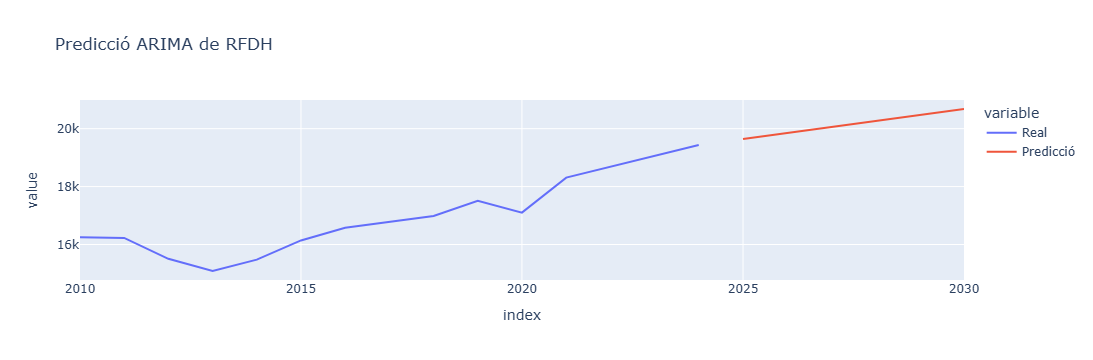

In [33]:
# Prediccions de RFDH al futur amb ARIMA

s = df2["RFDH"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de RFDH")
fig.show()

                               SARIMAX Results                                
Dep. Variable:                Aturats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -121.289
Date:                Thu, 05 Feb 2026   AIC                            248.578
Time:                        10:30:10   BIC                            250.495
Sample:                    01-01-2010   HQIC                           248.400
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3866      0.753      0.514      0.608      -1.089       1.862
ma.L1         -0.2088      0.855     -0.244      0.807      -1.885       1.467
sigma2      1.705e+06   1.14e+06      1.491      0.1

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



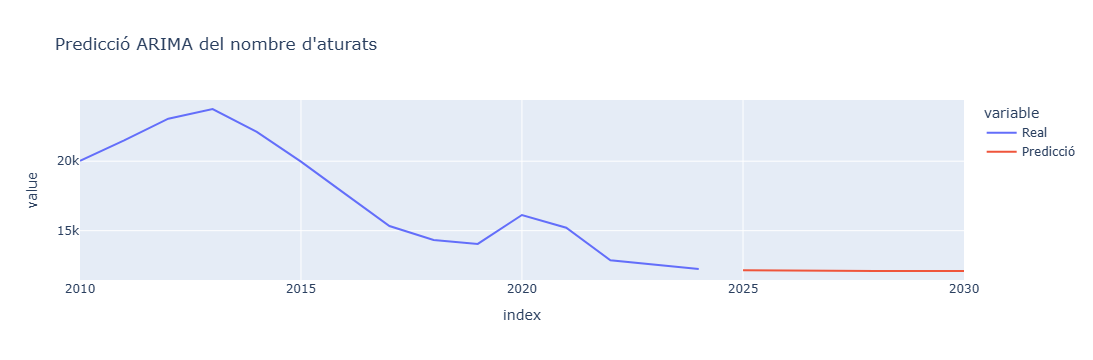

In [34]:
# Prediccions de Aturats al futur amb ARIMA

s = df2["Aturats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA del nombre d'aturats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:     Habitatges acabats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -92.482
Date:                Thu, 05 Feb 2026   AIC                            190.965
Time:                        10:30:11   BIC                            192.882
Sample:                    01-01-2010   HQIC                           190.787
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8172      0.748      1.092      0.275      -0.649       2.283
ma.L1         -0.9994     71.710     -0.014      0.989    -141.549     139.550
sigma2      3.022e+04   2.15e+06      0.014      0.9

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



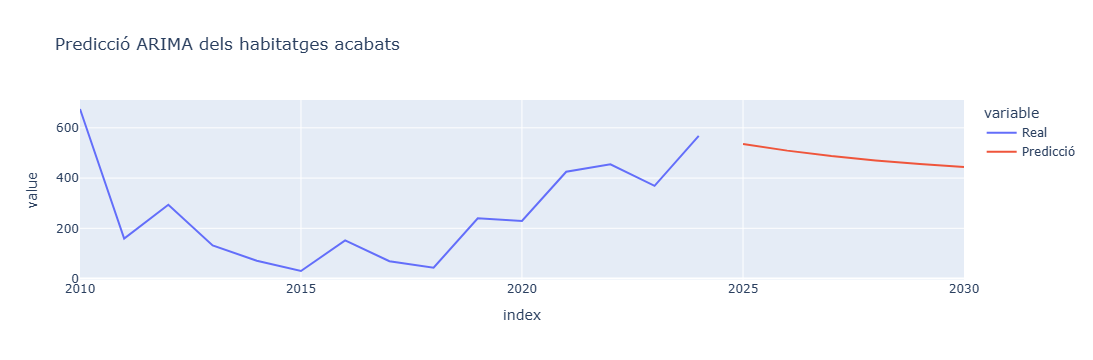

In [35]:
# Prediccions de Habitatges acabats al futur amb ARIMA

s = df2["Habitatges acabats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA dels habitatges acabats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:             Naixements   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -85.824
Date:                Thu, 05 Feb 2026   AIC                            177.649
Time:                        10:30:13   BIC                            179.566
Sample:                    01-01-2010   HQIC                           177.471
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.003    326.930      0.000       0.994       1.006
ma.L1         -0.9965      0.485     -2.056      0.040      -1.946      -0.047
sigma2      1.027e+04   4.81e-05   2.13e+08      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



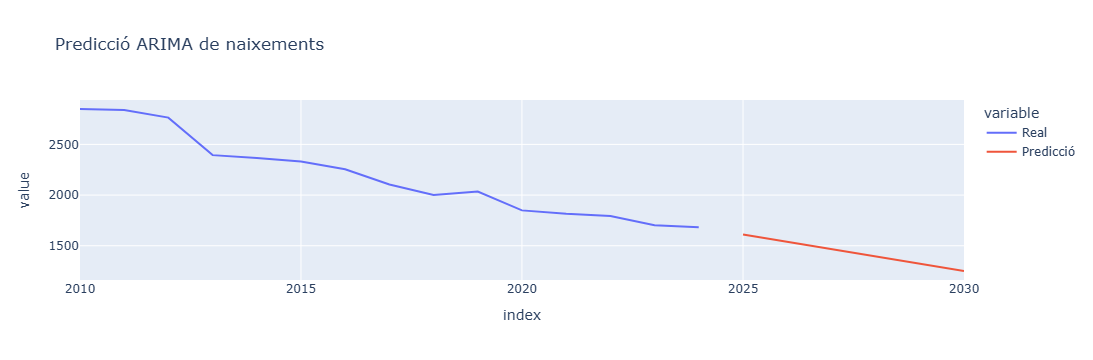

In [36]:
# Prediccions de Naixements acabats al futur amb ARIMA

s = df2["Naixements"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de naixements")
fig.show()

In [ ]:
# Prediccions de Defuncions al futur amb ARIMA

s = df2["Defuncions"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de defuncions")
fig.show()